# Do stuff with nc files from CIS-weekly 

***


In [12]:
import numpy as np 
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
# %matplotlib notebook


Weekly data starts from 1968-6-25 and ends 2020-10-26. 

## Load in data

In [14]:
# files = glob.glob('/extra-space1/data/tikoralukupload/cis-weekly/nc/*')
path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'
region = 'HB'
nc = Dataset(path + region + '.nc', 'r')

lon = nc.variables['longitude'][600:1450,1700:]
lat = nc.variables['latitude'][600:1450,1700:]
land = nc.variables['land'][600:1450,1700:]
E_CT = nc.variables['E_CT'][:,600:1450,1700:]
juld = nc.variables['juld'][:]


### Separate data into years

In [15]:
# Convert dates
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld

dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
years = [dates[tt].year for tt in range(len(juld))]
# months = [dates[tt].month for tt in range(len(tEC))]
# days = [dates[tt].day for tt in range(len(tEC))]


### Now plot yearly means!

In [16]:
CT = np.nan*np.ones(E_CT.shape)
# CT = E_CT
CT[E_CT==1] = 10
CT[E_CT==2] = 20
CT[E_CT==3] = 30
CT[E_CT==4] = 40
CT[E_CT==5] = 50
CT[E_CT==6] = 60
CT[E_CT==7] = 70
CT[E_CT==8] = 80
CT[E_CT==9] = 90
CT[E_CT==10] = 95
CT[E_CT==11] = 100

In [18]:
# Mask out land
# E_CTma = np.ma.filled(E_CT.astype(float), np.nan)
years_unique = np.unique(years)
# Calculate yearly means
ymeans=[]

for year in years_unique:
    inds = np.array(years)==year
    ymeans.append(np.nanmean(CT[inds,:,:],axis=0))

ymeans = np.array(ymeans)

<ipython-input-18-b1551efa6441>:9: RuntimeWarning: Mean of empty slice
  ymeans.append(np.nanmean(CT[inds,:,:],axis=0))


In [26]:
#Using cartopy 
import cartopy
import cartopy.crs as ccrs
%matplotlib notebook

#Declare the land and ocean parameters
LAND_highres = cartopy.feature.NaturalEarthFeature('physical', 'land', '10m',
edgecolor='black',
facecolor=('silver'),
linewidth=1)
OCEAN_highres = cartopy.feature.NaturalEarthFeature('physical', 'ocean', '10m',
facecolor='dimgray')

#Declare the lat and lon boundaries for the map and data
domain = [99, 99, -99, -99]
domain[0] = np.min(lat_ice) # South
domain[1] = np.min(lon_ice) # West
domain[2] = np.max(lat_ice) # North
domain[3] = np.max(lon_ice) # East
domain = list(np.array(domain) + np.array([0, +8, +1, -7]))

aoi_map = [domain[0], domain[2], domain[1], domain[3]]
# Rotation for vertical coast
rot = ccrs.RotatedPole(pole_latitude=55,pole_longitude=160)

fig = plt.figure(figsize=(10,5))
fig.add_axes([0.1, 0.1, 0.7, 0.75])
ax = plt.axes(projection=rot)

#Plot the map
ax.add_feature(LAND_highres,zorder=2)
ax.add_feature(OCEAN_highres,zorder=3)
ax.set_extent([aoi_map[2], aoi_map[3], aoi_map[0], aoi_map[1]])
ax.coastlines(resolution='10m',linewidth=0.35,zorder=3)

# #Plot results
transform = rot.transform_points(rot,lon,lat)
x_n = transform[...,0]
y_n = transform[...,1]
# plt.pcolormesh(x_n,y_n,dum,transform=ccrs.PlateCarree(),cmap='coolwarm',zorder=4)
start_date = datetime.date(2002, 1, 1)
tdelta = datetime.timedelta(days=1)

ims = []
cmap = cmocean.cm.ice
for i in range(len(ymeans)):
#     ax.set_axis_off()
    txt = plt.text(0.5, 1.01, str(start_date), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    im = plt.pcolormesh(x_n,y_n,ymeans[0,:,:],cmap='Blues_r',transform=ccrs.PlateCarree(),zorder=4)
    ims.append([im,txt])
    start_date += tdelta
cb_ax = fig.add_axes([0.68, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)
cbar.set_ticks([0,0.2,0.4,0.6,0.8,1])
cbar.set_ticklabels(['0','20','40','60','80','100'])
ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False,
                                repeat_delay=1000, repeat=True)



NameError: name 'lat_ice' is not defined

### Animate with coastline

<IPython.core.display.Javascript object>


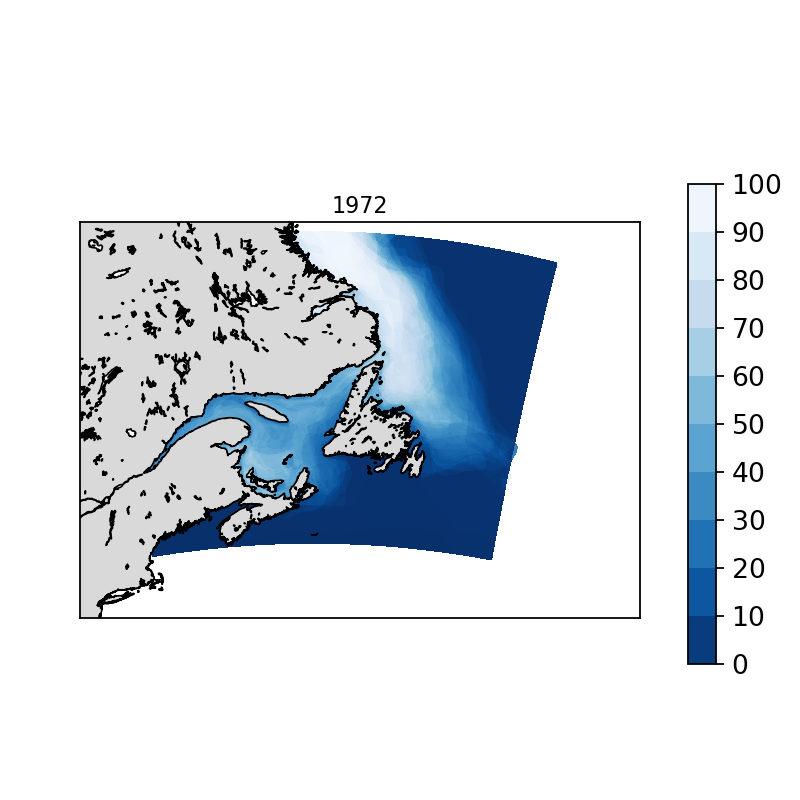

In [15]:
# Make it prettier

import mpl_toolkits.basemap as bm

%matplotlib notebook
years_unique = np.unique(years)

domain = [99, 99, -99, -99]
domain[0] = np.min(latEC) # South
# domain[2] = np.max(latEC) # North
domain[2] = 65
domain[1] = np.min(lonEC) # West
domain[3] = np.max(lonEC) # East
# domain = list(np.array(domain) + np.array([+0.5, +0.7, 0.2, 1.3]))
domain = list(np.array(domain) + np.array([+6, +6, -8, -7]))

proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='h')
lonproj, latproj = proj(lonEC, latEC)

fig = plt.figure(figsize = (5, 5))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.75])
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)
cmap = plt.cm.get_cmap('Blues_r')
# plt.pcolor(lonproj, latproj, n_ctEC[-25,:,:], cmap=cmap)

ims = []
cnt=0
for i in range(len(years_unique)):
#     ax.set_axis_off()
#     txt = plt.text(1,1,str(dates[i]),fontsize=16)
    txt = plt.text(0.5, 1.01, years_unique[i], horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
    im = plt.pcolor(lonproj, latproj, ymeans[cnt,:,:], cmap=cmap, vmin=0, vmax=100)
    ims.append([im,txt])
    cnt+=1
    
# cb_ax = fig.add_axes([0.86, 0.17, 0.035, 0.6]) #[left, bottom, width, height]   
# cbar = fig.colorbar(im, cax=cb_ax)
# cbar.ax.tick_params(labelsize=12)
ticks = np.arange(0,110,10)
cb_ax = fig.add_axes([0.86, 0.17, 0.035, 0.6]) #[left, bottom, width, height]   
cbar = fig.colorbar(im, cax=cb_ax, boundaries=np.arange(0, 110, 10))
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(ticks)
cbar.ax.tick_params(labelsize=12)
# cbar.set_clim(0, 100)
plt.clim(0,100)

# Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=10, bitrate=1800)


ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False,
                                repeat_delay=1000, repeat=True)

ani.save('/home/mwang/NCT_weekly_coast.gif', writer='imagemagick',fps=4)

In [41]:
ticks = np.arange(0,110,10)
cb_ax = fig.add_axes([0.86, 0.17, 0.035, 0.6]) #[left, bottom, width, height]   
cbar = fig.colorbar(im, cax=cb_ax, boundaries=np.arange(0, 110, 10))
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(ticks)
cbar.ax.tick_params(labelsize=12)
# cbar.set_clim(0, 100)
plt.clim(0,100)

# Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=10, bitrate=1800)


ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False,
                                repeat_delay=1000, repeat=True)

ani.save('/home/mwang/NCT_weekly_coast.gif', writer='imagemagick',fps=4)

In [69]:
ticks = np.arange(0,110,10)
cb_ax = fig.add_axes([0.86, 0.17, 0.035, 0.6]) #[left, bottom, width, height]   
cbar = fig.colorbar(im, cax=cb_ax, boundaries=np.arange(0, 110, 10))
cbar.set_ticks(ticks)
cbar.ax.set_yticklabels(ticks)
cbar.ax.tick_params(labelsize=12)
# cbar.set_clim(0, 10w0)
plt.clim(0,100)

# Set up formatting for the movie files
# Writer = animation.writers['ffmpeg']
# writer = Writer(fps=10, bitrate=1800)

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=False,
                                repeat_delay=1000, repeat=True)

ani.save('/home/mwang/NCT_weekly_coast.gif', writer='imagemagick',fps=4)

# Plot landfast ice

Text(0.5, 1.0, '2020-03-09')

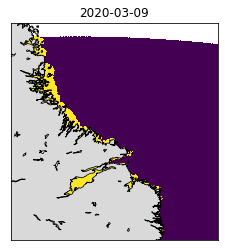

In [270]:
#Eric's code

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.interactive(True)
from datetime import date
from netCDF4 import Dataset

path = '/home/mwang/CIS-project/data/cis-weekly/nc/'

# Read in data
nc = Dataset(path + 'EC.nc', 'r')
lon = nc.variables['longitude'][:]
lat = nc.variables['latitude'][:]
juld = nc.variables['juld'][:]
C = nc.variables['n_ct'][:]

# Date time information
time = juld + date(1950,1,1).toordinal()
dates = [date.fromordinal(time[tt]) for tt in range(len(time))]
years = np.array([dates[tt].year for tt in range(len(time))])
months = np.array([dates[tt].month for tt in range(len(time))])

# Some stats!
tt = -25 # Just to try

# Concentration map
plt.clf(); plt.pcolor(lon, lat, C[tt,:,:]); plt.colorbar()
plt.xlim(-63, -53); plt.ylim(52, 58)

# Find the landfast ice (assume C=100% for landfast)
plt.clf(); plt.pcolor(lon, lat, C[tt,:,:]==100.); plt.colorbar()
plt.xlim(-63, -53); plt.ylim(52, 58)

# Make the map prettier
import mpl_toolkits.basemap as bm
domain = [52., -63., 58., -53.]
proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='h')
lonproj, latproj = proj(lon, lat)

plt.clf()
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)
plt.pcolor(lonproj, latproj, C[tt,:,:]==100.)
plt.title(dates[tt])

<ipython-input-4-893153a51d2e>:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.clf(); plt.pcolor(lon, lat, C[tt,:,:]); plt.colorbar()
<ipython-input-4-893153a51d2e>:33: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.clf(); plt.pcolor(lon, lat, C[tt,:,:]==100.); plt.colorbar()


OSError: Unable to open boundary dataset file. Only the 'crude' and  'low',
resolution datasets are installed by default.
If you are requesting an, 'intermediate', 'high' or 'full'
resolution dataset, you may need to download and install those
files separately with
`conda install -c conda-forge basemap-data-hires`.

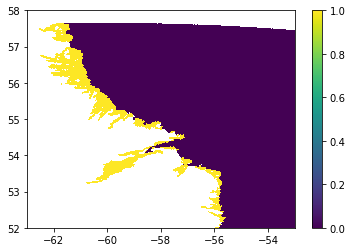

In [4]:
# Eric's code

import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.interactive(True)
from datetime import date
from netCDF4 import Dataset

path = '/home/mwang/CIS-project/data/cis-weekly/nc/'

# Read in data
nc = Dataset(path + 'EC.nc', 'r')
lon = nc.variables['longitude'][:]
lat = nc.variables['latitude'][:]
juld = nc.variables['juld'][:]
C = nc.variables['n_ct'][:]

# Date time information
time = juld + date(1950,1,1).toordinal()
dates = [date.fromordinal(time[tt]) for tt in range(len(time))]
years = np.array([dates[tt].year for tt in range(len(time))])
months = np.array([dates[tt].month for tt in range(len(time))])

# Some stats!
tt = -25 # Just to try

# Concentration map
plt.clf(); plt.pcolor(lon, lat, C[tt,:,:]); plt.colorbar()
plt.xlim(-63, -53); plt.ylim(52, 58)

# Find the landfast ice (assume C=100% for landfast)
plt.clf(); plt.pcolor(lon, lat, C[tt,:,:]==100.); plt.colorbar()
plt.xlim(-63, -53); plt.ylim(52, 58)

# Make the map prettier
import mpl_toolkits.basemap as bm
import cmocean
domain = [52., -63., 58., -53.]
proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='h')
lonproj, latproj = proj(lon, lat)

plt.clf()
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)
plt.pcolor(lonproj, latproj, C[tt,:,:]==100., cmap=cmocean.cm.ice)
plt.title(dates[tt])
plt.clim(-1.5, 1)

# Define landfast ice
fast = C == 100.
tt = months == 3 # Look at all March's
N = tt.sum()
pfast = np.sum(fast[tt,:,:], axis=0)/N # Probability of ice being landfast

# cmap = mpl.colors.ListedColormap(cmocean.cm.ice(np.linspace(50,256,10).astype(int)))

# # Probability of landfast ice
# plt.clf()
# proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
# proj.drawcoastlines(color='k', linewidth=0.75)
# #plt.pcolor(lonproj, latproj, pfast, cmap=cmocean.cm.ice)
# plt.pcolor(lonproj, latproj, pfast, cmap=cmap)
# plt.colorbar()
# plt.clim(0, 1)

# Plot the sina (landfast ice edge) for each year
years_unique = np.unique(years)
colours = cmocean.cm.ice(np.linspace(50,256,len(years_unique)))

plt.clf()
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)
cnt = 0
for yr in years_unique:
    which = (years == yr) * (months == 3)
    if np.sum(which) >= 1:
        tt = np.where(which)[0][0]
        plt.contour(lonproj, latproj, C[tt,:,:], levels=[99.9], colors=[colours[cnt,:-1]])
    cnt += 1



In [ ]:
# Landfast ice over time? 

nm=[]
for year in range(1969,2020):
    ind = np.array(years)==year
    nm.append(np.nanmean(C[ind,:,:],axis=0))

nm_all = np.nanmean(nm,axis=0)
plt.figure(figsize=(7,7))

proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)
plt.pcolor(lonproj,latproj,nm_all)
# plt.xlim(-63, -53); plt.ylim(52, 58)
plt.title('Average Landfast Ice over all years')

## Time series of sina from Labrador community

In [5]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.interactive(True)
from datetime import date
from netCDF4 import Dataset

path = '/home/mwang/CIS-project/data/cis-weekly/nc/'

# Read in data
nc = Dataset(path + 'EC.nc', 'r')
lon = nc.variables['longitude'][:]
lat = nc.variables['latitude'][:]
juld = nc.variables['juld'][:]
C = nc.variables['n_ct'][:]

# Date time information
time = juld + date(1950,1,1).toordinal()
dates = [date.fromordinal(time[tt]) for tt in range(len(time))]
years = np.array([dates[tt].year for tt in range(len(time))])
months = np.array([dates[tt].month for tt in range(len(time))])

# Some stats!
tt = -25 # Just to try

In [35]:
# Find community location

# Nain
# lon0 = -61.669163
# lat0 = 56.522341

# Hopedale
lat0 = 55.467491, 
lon0 = -60.216200

d = np.sqrt((lon-lon0)**2 + (lat-lat0)**2) 
# index for lon and lat of lon0 and lat0 
loc = np.unravel_index(np.argmin(d, axis=None), d.shape)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


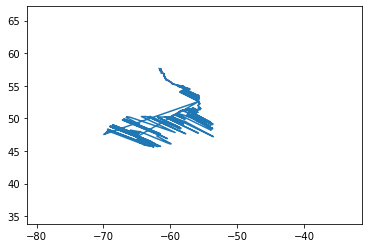

In [36]:
# Get sina line
CS = plt.contour(lon, lat, C[-25,:,:], levels=[99.9])
sinaline = CS.allsegs
sina = np.concatenate(np.concatenate(sinaline, axis=0))
xarr = sina[:,0]
yarr = sina[:,1]
plt.plot(xarr,yarr)

# Find closest point of sina to Nain
d = np.sqrt((xarr-lon0)**2 + (yarr-lat0)**2) 
iloc = np.unravel_index(np.argmin(d, axis=None), d.shape)

# Find index of closest point in lon and lat
d = np.sqrt((lon-xarr[iloc])**2 + (lat-yarr[iloc])**2) 
# index for lon and lat of lon0 and lat0 
sinaloc = np.unravel_index(np.argmin(d, axis=None), d.shape)

<ipython-input-44-bbf2cdea7bbb>:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(lonproj,latproj,C[-25,:,:]==100.,cmap=plt.get_cmap('Blues'))


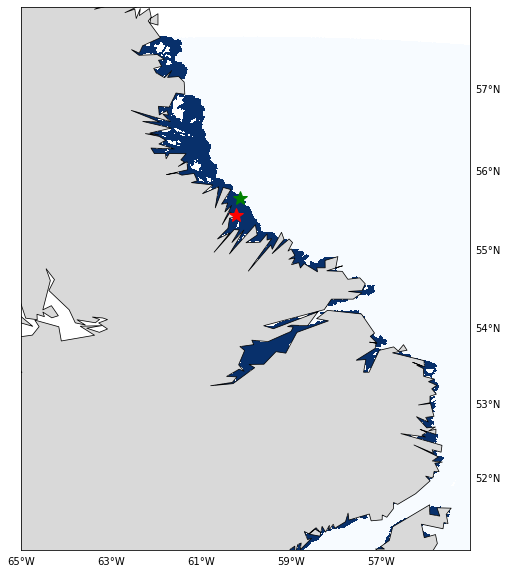

In [44]:
plt.figure(figsize=(10,10))

domain = [51., -65., 58., -55.]
proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='l')
lonproj, latproj = proj(lon, lat)

# proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)

# Add ticks
parallels = np.arange(domain[0],domain[2],1.)
# labels = [left,right,top,bottom]
proj.drawparallels(parallels,labels=[False,True,True,False], linewidth=0)
meridians = np.arange(domain[1],domain[3],2.)
proj.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0)

# Plot Nain
# plt.plot(lonproj[loc],latproj[loc],'r*',markersize=15)

plt.plot(lonproj[sinaloc],latproj[sinaloc],'g*',markersize=15, label='Closest sina')
plt.plot(lonproj[loc],latproj[loc],'r*',markersize=15,label='Community location')
plt.pcolor(lonproj,latproj,C[-25,:,:]==100.,cmap=plt.get_cmap('Blues'))

# Line for finding edge - constant indexing but not good approximation
# plt.plot(lonproj[913],latproj[913],'y-')
# Edge of LF (sina)
# plt.plot(lonproj[913,778],latproj[913,778],'g*',markersize=15)


This is obviously not ideal. Next step is to figure out how to get the coordinate of the sina closest to the community. For now, distance along the transect is the easiest.

In [176]:
# Where is the edge of the landfast ice? 
LF = C[-25,913,:]==100
sina = np.max(np.where(LF==True))

In [158]:
# Convert to distance from Nain. 1 degree lat = 110km. 1 degree lon = 111.320*cos(latitude) km.
def deg2km(lat,lon):
    u_km = lon*111*np.cos(lat)
    v_km = lat*111
    return abs(u_km), abs(v_km)

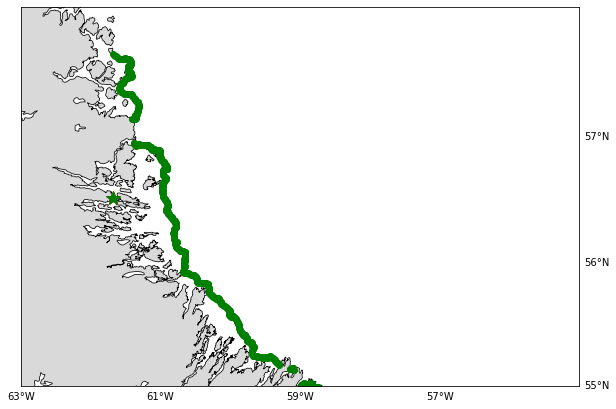

In [98]:
plt.figure(figsize=(10,10))

domain = [55., -63., 58., -55.]
proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='h')
lonproj, latproj = proj(lon, lat)
xarrproj, yarrproj = proj(xarr, yarr)

# proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)

# Add ticks
parallels = np.arange(domain[0],domain[2],1.)
# labels = [left,right,top,bottom]
proj.drawparallels(parallels,labels=[False,True,True,False], linewidth=0)
meridians = np.arange(domain[1],domain[3],2.)
proj.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0)

# Plot Nain
plt.plot(lonproj[loc],latproj[loc],'r*',markersize=15)
# plt.pcolor(lonproj,latproj,C[tt,:,:]==100.,cmap=plt.get_cmap('Blues'))

# Line for finding edge - constant indexing but not good approximation
# plt.plot(lonproj[913],latproj[913],'y-')
# Edge of LF (sina)
plt.plot(lonproj[sinaloc],latproj[sinaloc],'g*',markersize=15)
# CS = plt.contour(lonproj, latproj, C[-25,:,:], levels=[99.9])
plt.plot(xarrproj,yarrproj,'go')

# Distance from Sina to community

The closest point may not always be right... Sometimes involves travelling on land (ie. for Nain)

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


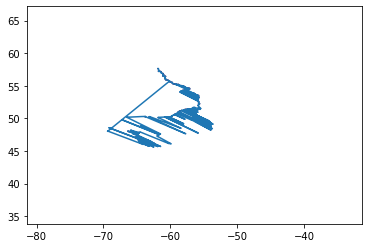

In [33]:
# Find community location

llon0 = -61.669163
llat0 = 56.522341
d = np.sqrt((lon-llon0)**2 + (lat-llat0)**2) 
# index for lon and lat of lon0 and lat0 
loc = np.unravel_index(np.argmin(d, axis=None), d.shape)

plt.figure()
CS = plt.contour(lon, lat, C[-22,:,:], levels=[99.9])
sina = CS.allsegs
sina = np.concatenate(np.concatenate(sina, axis=0))
xarr = sina[:,0]
yarr = sina[:,1]
plt.plot(xarr,yarr)

# Find closest point of sina to Nain
d = np.sqrt((xarr-llon0)**2 + (yarr-llat0)**2) 
iloc = np.unravel_index(np.argmin(d, axis=None), d.shape)

# Find index of closest point in lon and lat
d = np.sqrt((lon-xarr[iloc])**2 + (lat-yarr[iloc])**2) 
# index for lon and lat of lon0 and lat0 
sinaloc = np.unravel_index(np.argmin(d, axis=None), d.shape)

[]

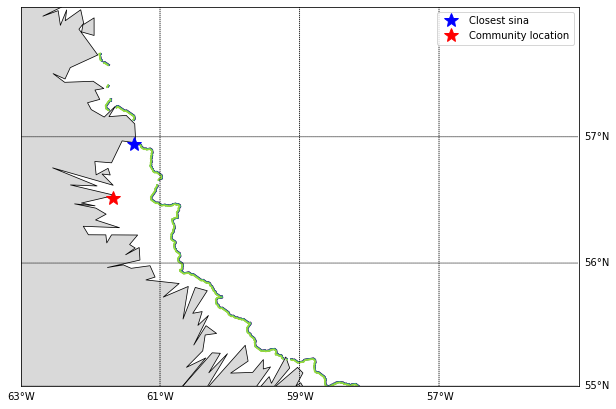

In [34]:
plt.figure(figsize=(10,10))
domain = [55., -63., 58., -55.]
# domain = [50, -63., 58., -50.]

proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='l')
lonproj, latproj = proj(lon, lat)

# proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)

# Add ticks
parallels = np.arange(domain[0],domain[2],1.)
# labels = [left,right,top,bottom]
proj.drawparallels(parallels,labels=[False,True,True,False], linewidth=1)
meridians = np.arange(domain[1],domain[3],2.)
proj.drawmeridians(meridians,labels=[True,False,False,True],linewidth=1)
# plt.contour(lonproj, latproj, Carr[-25,:,:]==100)
plt.contour(lonproj, latproj, C[-22,:,:]==100)
plt.plot(lonproj[sinaloc],latproj[sinaloc],'b*',markersize=15, label='Closest sina')
plt.plot(lonproj[loc],latproj[loc],'r*',markersize=15,label='Community location')
# plt.plot(xarrproj[iloc],yarrproj[iloc],'b*',markersize=15)
plt.legend()

plt.plot()
            
# dat0= CS.allsegs[0][0]
# plt.plot(dat0[:,0],dat0[:,1])

### Time series of distance to sina

In [1]:
# Convert to distance from degree. 1 degree lat = 110km. 1 degree lon = 111.320*cos(latitude) km.
def deg2km(lat,lon):
    u_km = lon*111*np.cos(lat)
    v_km = lat*111
    return abs(u_km), abs(v_km)

years_unique = np.unique(years)
# Calculate distance, loop over some dates
dLF = np.zeros(len(years_unique))

cnt=0
for yr in years_unique:
    which = (years == yr) * (months == 1)
    if np.sum(which) >= 1:
        tt = np.where(which)[0][0]
        CS = plt.contour(lon, lat, C[tt,:,:], levels=[99.9])
        # Get contour info
        sina = CS.allsegs
        sina = np.concatenate(np.concatenate(sina, axis=0))
        xarr = sina[:,0]
        yarr = sina[:,1]

        # Find closest point of sina to Nain
        d = np.sqrt((xarr-llon0)**2 + (yarr-llat0)**2) 
        iloc = np.unravel_index(np.argmin(d, axis=None), d.shape)

        # Find index of closest point in lon and lat
        d = np.sqrt((lon-xarr[iloc])**2 + (lat-yarr[iloc])**2) 
        # index for lon and lat of community coordinates
        sinaloc = np.unravel_index(np.argmin(d, axis=None), d.shape)
        uc_km, vc_km = deg2km(llat0, llon0)
        us_km, vs_km = deg2km(lat[sinaloc],lon[sinaloc])
        dLF[cnt] = np.sqrt((uc_km - us_km)**2 + (vc_km - vs_km)**2)
        cnt += 1

plt.clf()
# Some distances are very large if there is no landfast ice near the community, but is present somewhere in the domain. 
dLF[dLF>1000]=np.nan
plt.plot(years_unique,dLF)
plt.title('January')
plt.ylabel('Distance to sina (km)')

NameError: name 'np' is not defined

### Plot map with distance from sina

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[]

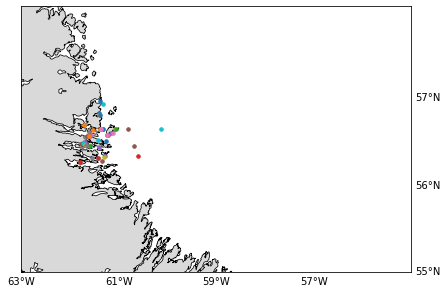

In [40]:
plt.figure(figsize=(7,7))
domain = [55., -63., 58., -55.]
# domain = [50, -63., 58., -50.]

proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='h')
lonproj, latproj = proj(lon, lat)

# proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)

# Add ticks
parallels = np.arange(domain[0],domain[2],1.)
# labels = [left,right,top,bottom]
proj.drawparallels(parallels,labels=[False,True,True,False], linewidth=0)
meridians = np.arange(domain[1],domain[3],2.)
proj.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0)
# plt.contour(lonproj, latproj, Carr[-25,:,:]==100)

cnt=0
ims=[]
sinaloc = []
for yr in years_unique:
    which = (years == yr) * (months == 1)
    if np.sum(which) >= 1:
        tt = np.where(which)[0][0]
        CS = plt.contour(lon, lat, C[tt,:,:], levels=[99.9])
        # Get contour info
        sina = CS.allsegs
        sina = np.concatenate(np.concatenate(sina, axis=0))
        xarr = sina[:,0]
        yarr = sina[:,1]

        # Find closest point of sina to Nain
        d = np.sqrt((xarr-llon0)**2 + (yarr-llat0)**2) 
        iloc = np.unravel_index(np.argmin(d, axis=None), d.shape)

        # Find index of closest point in lon and lat
        d = np.sqrt((lon-xarr[iloc])**2 + (lat-yarr[iloc])**2) 
        # index for lon and lat of community coordinates
        sinaloc = np.unravel_index(np.argmin(d, axis=None), d.shape)
        plt.plot(lonproj[sinaloc], latproj[sinaloc],'.',markersize=7)
        
plt.plot(llon0, llat0, 'k*')        
# for i in range(len(years_unique)):
#     ice = plt.contour(lonproj, latproj, C[tt,:,:]==100)
#     im = plt.plot(lonproj[sinaloc[i]],latproj[sinaloc[i]],'^',markersize=5)
#     txt = plt.text(0.5, 1.01, years_unique[i], horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
#     ims.append([ice, im, txt])

        
# ims = []

# for i in range(len(years_unique)):
# #     ax.set_axis_off()
# #     txt = plt.text(1,1,str(dates[i]),fontsize=16)
#     txt = plt.text(0.5, 1.01, years_unique[i], horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)
#     im = plt.pcolor(lonproj, latproj, C[i,:,:], cmap=cmap, vmin=0, vmax=100)
#     ims.append([im,txt])

# ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=False,
#                                 repeat_delay=1000, repeat=True)

# ani.save('/home/mwang/test.gif', writer='imagemagick',fps=4)
# plt.plot(lonproj[loc],latproj[loc],'r*',markersize=15,label='Community location')
# plt.plot(xarrproj[iloc],yarrproj[iloc],'b*',markersize=15)
# plt.legend()

plt.plot()

***

# Decomposed time series

Decompose a y(t) time series as:

y(t) = y-bar + y_trend(t) + y'(t)

where

y-bar is the mean value over all time. We could also consider this to be time-varying and take means for specific months or seasons over all years.

y_trend(t) is the long-term change over the full record. Could be modeled as a linear trend, or less likely as something more complex (thing trend with a quadratic term for dec/acceleration effects).

y' is the variability or anomalies. This consists of the variations of y about the mean and trend. This can be analysed using time series methods like the auto-correlation function, power spectra, etc. And if we have y' at multiple locations (e.g. y' is ice concentration over time for many pixels over space) then something like empirical orthogonal functions or self organising maps can be used to reduce the complexity of this term, and draw out patterns we can better understand.

For each (x,y) pixel, calculate the means (probably monthly means is best) and the trend.  And map these.  So that would be a map of the mean for each month (say Dec-June for the east coast) and a map for the slope of the trend line.  Then you have the variability left over. For starters you could just map the standard deviation of this variability so we can see where it is greatest.

***

**Start with concentration**

In [72]:
from netCDF4 import Dataset

path = '/home/mwang/CIS-project/data/cis-weekly/nc/'

# Read in data
nc = Dataset(path + 'EC.nc', 'r')
lon = nc.variables['longitude'][:]
lat = nc.variables['latitude'][:]
juld = nc.variables['juld'][:]
C = nc.variables['n_ct'][:]

# Date time information
time = juld + date(1950,1,1).toordinal()
dates = [date.fromordinal(time[tt]) for tt in range(len(time))]
years = np.array([dates[tt].year for tt in range(len(time))])
months = np.array([dates[tt].month for tt in range(len(time))])

Plot time series and trendline

In [75]:
# Example location
lon0 = -59
lat0 = 50
d = np.sqrt((lon-lon0)**2 + (lat-lat0)**2) 
# index for lon and lat of lon0 and lat0 
loc = np.unravel_index(np.argmin(d, axis=None), d.shape)
print(loc)

(1391, 1271)


In [78]:
np.shape(trendline)

(1043, 850, 954)

y=-0.001627x + 52.631415


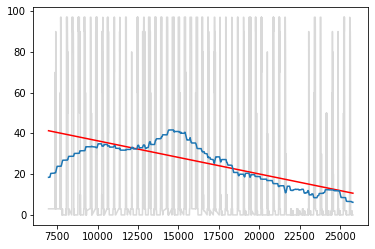

In [85]:
plt.figure()
plt.plot(juld, C[:,loc[0],loc[1]], color='0.85')
# calc the trendline (linear fitting)
z = np.polyfit(juld, C[:,loc[0],loc[1]], 1)
p = np.poly1d(z)
plt.plot(juld,p(juld),'r-')

# Plot running mean
N = 365
cumsum = np.convolve(C[:,loc[0],loc[1]], np.ones((N,))/N, mode='same')

plt.plot(juld,cumsum)

# the line equation:
print('y=%fx + %f'%(z[0],z[1]))

## Calculate trends and map them

Note: Do NOT attempt to find trends of variables with entire domain. It will crash from memory overload. Only works with sliced domains

Define decomposed variables for a defined domain

In [2]:
import numpy as np 
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal
import time
# %matplotlib notebook

In [97]:
# Read in data
# I determined previously that the index range below
# provided a reduced data set, with a zoom on the lab
# coast and shelf
path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'

nc = Dataset(path + 'HB.nc', 'r')
lon = nc.variables['longitude'][600:1450,1700:]
lat = nc.variables['latitude'][600:1450,1700:]
land = nc.variables['land'][600:1450,1700:]
juld = nc.variables['juld'][:]
E_CT = nc.variables['E_CT'][:,600:1450,1700:]
E_FA = nc.variables['E_FA'][:,600:1450,1700:]
E_SA = nc.variables['E_SA'][:,600:1450,1700:]
nc.close()

In [115]:
ybar = np.nanmean(E_CT, axis=0)

In [106]:
n = 850 # shape of lon
m = 954

ytrend=np.zeros((n,m))

for i in range(n):
    for j in range(m):
        z = np.polyfit(juld, E_CT[:,i,j], 1)
        ytrend[i,j] = z[0]                          

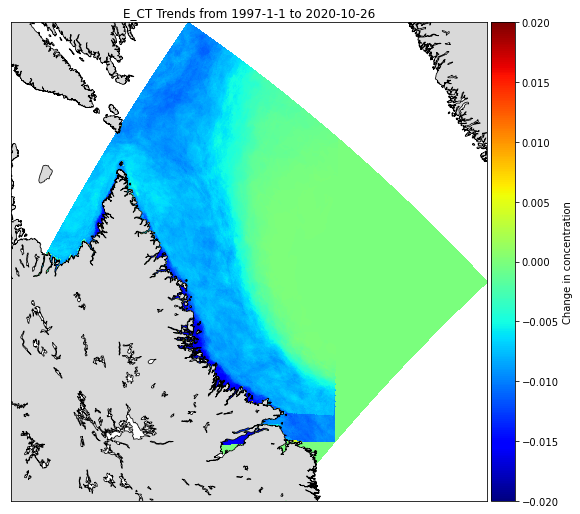

In [114]:
# Map trends
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.75])

domain = [99, 99, -99, -99]
domain[0] = np.min(lat) # South
domain[2] = np.max(lat) # North
domain[1] = np.min(lon) # West
domain[3] = np.max(lon) # East
# domain = list(np.array(domain) + np.array([+0.5, +0.7, 0.2, 1.3]))
# domain = list(np.array(domain) + np.array([+6, +3, -5, -9]))

proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='h')
lonproj, latproj = proj(lon, lat)
lonprojHB1, latprojHB1 = proj(lonHB1, latHB1)
lonprojHB2, latprojHB2 = proj(lonHB2, latHB2)


# proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)

# Add ticks
# parallels = np.arange(domain[0],domain[2],1.)
# labels = [left,right,top,bottom]
# proj.drawparallels(parallels,labels=[False,True,True,False], linewidth=0)
# meridians = np.arange(domain[1],domain[3],2.)
# proj.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0)

# im = plt.pcolormesh(lonprojHB1, latprojHB1, ytrend_HB1, cmap='jet')
# plt.pcolormesh(lonprojHB2, latprojHB2, ytrend_HB2, cmap='jet')
# plt.pcolormesh(lonproj, latproj, ytrend, cmap='jet', shading='nearest')

im=plt.pcolormesh(lonproj,latproj,ytrend,cmap='jet',vmin=-0.02,vmax=0.02)

plt.title('E_CT Trends from 1997-1-1 to 2020-10-26')

ax = plt.gca()

# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Change in concentration')


The units of above are suspect. Since concentration is 0-11, so they are not actually expressed in tenths. 

***

# Read nc files with egg code

Dec 6

The variables need to be split up, cannot calculate trends of entire domain.

In [26]:
# HB1

path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'

ncdf = Dataset(path + 'HB.nc', 'r')

# land = ncdf.variables['land'][:]
# x = ncdf.variables['x'][:]
# y = ncdf.variables['y'][:]
lonHB1 = ncdf.variables['longitude'][:1297,:]
latHB1 = ncdf.variables['latitude'][:1297,:]
E_CTHB1 = ncdf.variables['E_CT'][:,:1297,:]


In [23]:
# HB2

path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'

ncdf = Dataset(path + 'HB.nc', 'r')

# land = ncdf.variables['land'][:]
# x = ncdf.variables['x'][:]
# y = ncdf.variables['y'][:]
lonHB2 = ncdf.variables['longitude'][1297:,:]
latHB2 = ncdf.variables['latitude'][1297:,:]
E_CTHB2 = ncdf.variables['E_CT'][:,1297:,:]

In [ ]:
# Convert stage of formation into some actual thicknesses
# got the list of all values present from np.unique(E_SA)
h_A = np.nan*np.ones(E_SA.shape)
h_A[E_SA==1] = 0.05
h_A[E_SA==4] = 0.125
h_A[E_SA==5] = 0.225
h_A[E_SA==7] = 0.50
h_A[E_SA==10] = 0.95
h_A[E_SA==11] = 1.60
h_A[E_SA==12] = 2.50